# Step 4: Compute Derived Products and Export Model Inputs

With data ingested into the container, we now compute derived products:

1. **Merged NDVI** - Combine Landsat + Sentinel for better temporal coverage (if both available)
2. **Dynamics** - Irrigation windows, groundwater subsidy, K parameters

Then we export the `prepped_input.json` file that the SWIM model needs.

The container's `compute` and `export` APIs make this straightforward:
- `container.compute.merged_ndvi()` - Merge sensors (already harmonized via SBAF)
- `container.compute.dynamics()` - Compute irrigation/groundwater parameters
- `container.export.prepped_input_json()` - Export model-ready JSON

In [1]:
import os
import sys
from pathlib import Path

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.container import open_container

## 1. Open the Container

In [2]:
project_dir = Path.cwd()
container_path = project_dir / 'data' / '1_Boulder.swim'

container = open_container(str(container_path), mode='r+')

print(f"Opened container: {container.project_name}")
print(f"Fields: {container.n_fields}")

Opened container: 1_Boulder
Fields: 78


## 2. Check Current Status

Let's verify the data was ingested correctly in the previous notebook.

In [3]:
print(container.query.status())

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim
  Storage: directory
  Fields: 78
  Date range: 2004-01-01 to 2022-12-31
  Days: 6940

DATA PATHS:
----------------------------------------

  derived/
    combined_ndvi/inv_irr: shape=(6940, 78), 5.5% valid
    combined_ndvi/irr: shape=(6940, 78), 6.5% valid
    dynamics/gwsub_data: shape=(78,), 100.0% non-empty
    dynamics/irr_data: shape=(78,), 100.0% non-empty
    dynamics/kc_max: shape=(78,), 100.0% valid
    dynamics/ke_max: shape=(78,), 100.0% valid
    merged_ndvi/inv_irr: shape=(6940, 78), 6.9% valid
    merged_ndvi/irr: shape=(6940, 78), 8.2% valid

  geometry/
    area_m2: shape=(78,), 100.0% valid
    lat: shape=(78,), 100.0% valid
    lon: shape=(78,), 100.0% valid
    properties/COUNTYNAME: shape=(78,), 100.0% non-empty
    properties/COUNTY_NO: shape=(78,), 100.0% valid
    properties/ITYPE: shape=(78,), 100.0% non-empty
    properties/MAPPEDBY: shape=(78,), 100.0% non-emp

## 2b. Visualize Landsat and Sentinel-2 NDVI

Before merging sensors, let's examine the individual NDVI time series from Landsat and Sentinel-2.

**Spectral Harmonization**: All NDVI values were harmonized to the Landsat 8 OLI reference
standard during Earth Engine extraction using Spectral Bandpass Adjustment Factors (SBAF).
This ensures consistent values across the 40-year satellite record without post-hoc bias correction.

Sentinel-2 NDVI loaded successfully


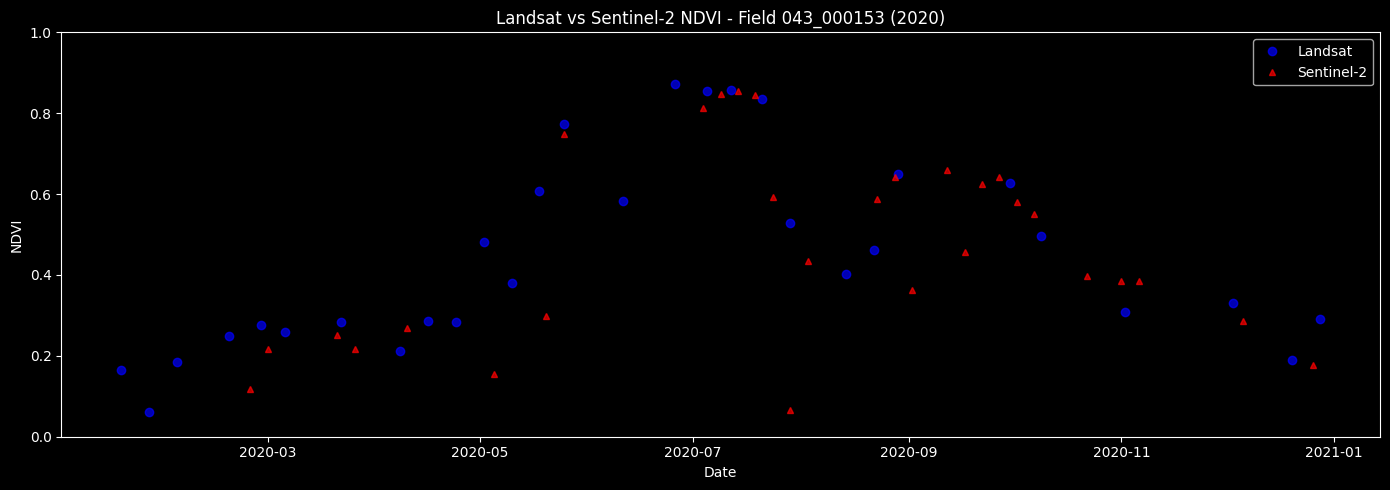


Observations in 2020:
  Landsat: 29
  Sentinel-2: 29
  Combined: 58


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load NDVI from both sensors
ndvi_landsat = container.to_xarray('remote_sensing/ndvi/landsat/irr')

# Check if Sentinel data exists
try:
    ndvi_sentinel = container.to_xarray('remote_sensing/ndvi/sentinel/irr')
    has_sentinel = True
    print("Sentinel-2 NDVI loaded successfully")
except KeyError:
    has_sentinel = False
    print("Sentinel-2 NDVI not available - showing Landsat only")

# Select a sample field and year (2020, when both sensors overlap)
sample_site = container.field_uids[0]
year = '2020'

fig, ax = plt.subplots(figsize=(14, 5))

# Plot Landsat NDVI
landsat_year = ndvi_landsat.sel(site=sample_site, time=year)
ax.plot(landsat_year.time, landsat_year, 'bo', markersize=6, alpha=0.7, label='Landsat')

# Plot Sentinel NDVI if available
if has_sentinel:
    sentinel_year = ndvi_sentinel.sel(site=sample_site, time=year)
    ax.plot(sentinel_year.time, sentinel_year, 'r^', markersize=5, alpha=0.7, label='Sentinel-2')

ax.set_ylabel('NDVI')
ax.set_xlabel('Date')
ax.set_title(f'Landsat vs Sentinel-2 NDVI - Field {sample_site} ({year})')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Count observations
n_landsat = int(landsat_year.notnull().sum())
print(f"\nObservations in {year}:")
print(f"  Landsat: {n_landsat}")
if has_sentinel:
    n_sentinel = int(sentinel_year.notnull().sum())
    print(f"  Sentinel-2: {n_sentinel}")
    print(f"  Combined: {n_landsat + n_sentinel}")

## 3. Merge NDVI from Multiple Sensors

If we have both Landsat and Sentinel NDVI, we can merge them into a single time series with
better temporal coverage. Since sensors were harmonized via SBAF during extraction, this is a
simple chronological merge - no bias correction needed.

In [5]:
print("Merging NDVI from Landsat and Sentinel...")
try:
    container.compute.merged_ndvi(
        masks=('irr', 'inv_irr'),
        instruments=('landsat', 'sentinel'),
        preference_order=('landsat', 'sentinel'),  # Prefer Landsat when both have data on same date
        overwrite=True
    )
    print("Merged NDVI computed successfully")
except Exception as e:
    print(f"Note: NDVI merge: {e}")
    print("Continuing with single-sensor NDVI...")

Merging NDVI from Landsat and Sentinel...
Merged NDVI computed successfully


## 4. Compute Dynamics

This is the heart of SWIM-RS preprocessing. The dynamics computation:

- **Irrigation Windows**: Identifies periods when irrigation likely occurred based on NDVI patterns
- **Groundwater Subsidy**: Detects fields receiving groundwater contributions to ET
- **K Parameters**: Computes ke_max (evaporation coefficient) and kc_max (crop coefficient)

The `use_mask=True` setting uses the annual irrigation fraction from IrrMapper/LANID to classify fields as irrigated vs non-irrigated. Otherwise (outside CONUS for now) we use a land cover map to determine if a field is a crop, and if so, apply irrigation if excess ET is detected or groundwater subsidy if excess ET is detected and it has a non-agricutltural land use.

In [6]:
print("Computing dynamics...")
container.compute.dynamics(
    etf_model='ssebop',
    masks=('irr', 'inv_irr'),
    irr_threshold=0.3,  # Fields with >30% irrigated area are considered irrigated
    use_mask=True,      # Use irrigation mask from properties
    use_lulc=False,     # Don't compute irrigation from water balance (CONUS mode)
    lookback=5,         # Days to look back for irrigation window extension
    overwrite=True,
)
print("Dynamics computed successfully")

Computing dynamics...
Dynamics computed successfully


## 5. Explore Computed Dynamics

Let's look at the irrigation windows for a sample field.

In [7]:
# Get irrigation windows for a few fields
sample_fields = container.field_uids[:3]

try:
    irr_windows = container.compute.irrigation_windows(fields=sample_fields)

    for fid in sample_fields:
        if fid in irr_windows:
            print(f"\nField {fid}:")
            for year in ['2018', '2019', '2020']:
                if year in irr_windows[fid]:
                    doys = irr_windows[fid][year].get('irr_doys', [])
                    if doys:
                        print(f"  {year}: {len(doys)} irrigation days (DOY {min(doys)}-{max(doys)})")
                    else:
                        print(f"  {year}: No irrigation detected")
except Exception as e:
    print(f"Could not retrieve irrigation windows: {e}")

## 6. Visualize NDVI with Computed Irrigation Days

Let's plot NDVI time series with the actual computed irrigation days from the dynamics.
The plot shows:
- **Green dots**: Raw NDVI observations from Landsat
- **Green line**: 32-day rolling mean of NDVI
- **Blue circles**: Days identified as potential irrigation days (from `irr_doys`)

The irrigation detection algorithm identifies days where NDVI is actively increasing during
the growing season, indicating active crop growth that typically requires irrigation.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline


Field 043_000704 in 2020: 713 irrigation days


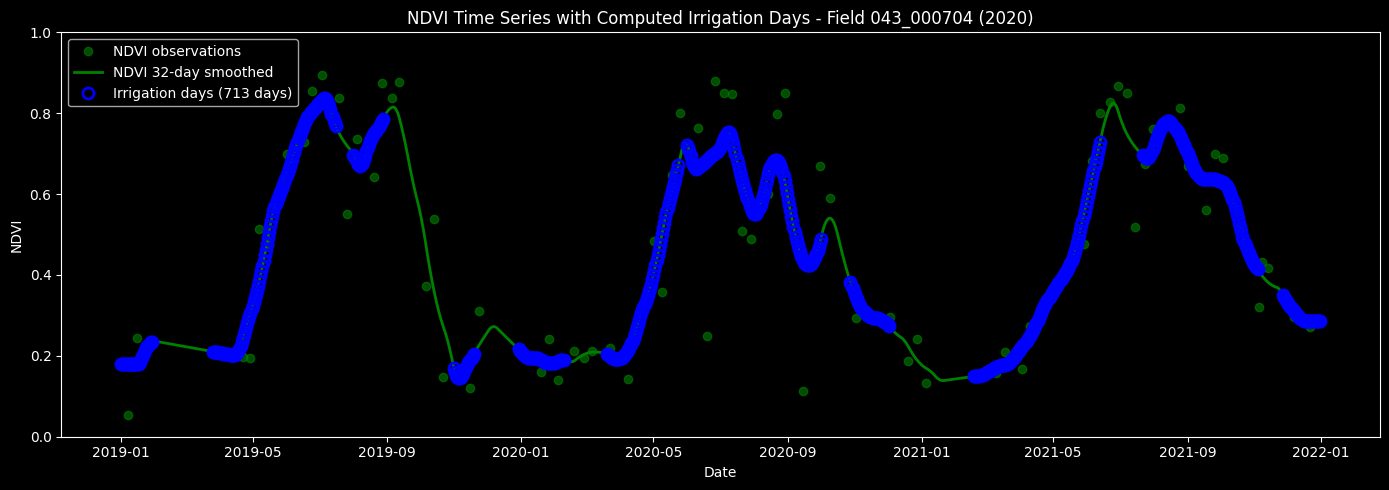

In [9]:
sample_site = '043_000704'
year = '2020'

# Get field time series with irr_doy binary column
df = container.query.field_timeseries(sample_site)

# Select the year
df_year = df.loc['2019': '2021'].copy()

# Apply the same interpolation as legacy dynamics code for NDVI smoothing
ndvi_col = 'remote_sensing_ndvi_landsat_irr'
df_year['ndvi_interp'] = df_year[ndvi_col].interpolate()
df_year['ndvi_interp'] = df_year['ndvi_interp'].bfill().ffill()
df_year['ndvi_smooth'] = df_year['ndvi_interp'].rolling(window=32, center=True).mean()
df_year['ndvi_smooth'] = df_year['ndvi_smooth'].bfill().ffill()

fig, ax = plt.subplots(figsize=(14, 5))

# Plot raw NDVI observations (only non-NaN values)
valid_obs = df_year[ndvi_col].dropna()
ax.plot(valid_obs.index, valid_obs.values, 'go', markersize=6, alpha=0.6, label='NDVI observations')

# Plot interpolated + smoothed NDVI (the continuous line)
ax.plot(df_year.index, df_year['ndvi_smooth'], 'g-', linewidth=2, label='NDVI 32-day smoothed')

# Mark computed irrigation days on the smoothed curve using irr_doy column
irr_days = df_year[df_year['irr_doy'] == 1]
n_irr = len(irr_days)

if n_irr > 0:
    ax.plot(irr_days.index, irr_days['ndvi_smooth'].values, 'bo', markersize=8,
           markerfacecolor='none', markeredgewidth=2,
           label=f'Irrigation days ({n_irr} days)')
    print(f"Field {sample_site} in {year}: {n_irr} irrigation days")
else:
    print(f"No irrigation days found for {sample_site} in {year}")

ax.set_ylabel('NDVI')
ax.set_xlabel('Date')
ax.set_title(f'NDVI Time Series with Computed Irrigation Days - Field {sample_site} ({year})')
ax.legend(loc='upper left')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 7. Check Container Status After Compute

In [10]:
print(container.query.status())

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim
  Storage: directory
  Fields: 78
  Date range: 2004-01-01 to 2022-12-31
  Days: 6940

DATA PATHS:
----------------------------------------

  derived/
    combined_ndvi/inv_irr: shape=(6940, 78), 5.5% valid
    combined_ndvi/irr: shape=(6940, 78), 6.5% valid
    dynamics/gwsub_data: shape=(78,), 100.0% non-empty
    dynamics/irr_data: shape=(78,), 100.0% non-empty
    dynamics/kc_max: shape=(78,), 100.0% valid
    dynamics/ke_max: shape=(78,), 100.0% valid
    merged_ndvi/inv_irr: shape=(6940, 78), 6.9% valid
    merged_ndvi/irr: shape=(6940, 78), 8.2% valid

  geometry/
    area_m2: shape=(78,), 100.0% valid
    lat: shape=(78,), 100.0% valid
    lon: shape=(78,), 100.0% valid
    properties/COUNTYNAME: shape=(78,), 100.0% non-empty
    properties/COUNTY_NO: shape=(78,), 100.0% valid
    properties/ITYPE: shape=(78,), 100.0% non-empty
    properties/MAPPEDBY: shape=(78,), 100.0% non-emp

## 8. Export Model Input JSON

Finally, export the `prepped_input.json` file that the SWIM model needs. This contains:
- Field properties (soils, area, irrigation fraction)
- Irrigation data (per-year irrigation windows)
- Time series data (meteorology, remote sensing)
- Field ordering

In [11]:
output_path = project_dir / 'data' / 'prepped_input.json'

print("Exporting model input JSON...")
container.export.prepped_input_json(
    output_path=str(output_path),
    etf_model='ssebop',
    masks=('irr', 'inv_irr'),
    instrument='landsat',
    use_merged_ndvi=True,
    irr_threshold=0.3
)

print(f"\nExported to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")

Exporting model input JSON...

Exported to: /home/dgketchum/code/swim-rs/examples/1_Boulder/data/prepped_input.json
File size: 383.4 MB


## 9. Verify Export

Let's peek at the exported JSON structure.

In [12]:
import json

with open(output_path, 'r') as f:
    data = json.load(f)

print("Top-level keys:", list(data.keys()))
print(f"\nNumber of fields in 'order': {len(data.get('order', []))}")
print(f"Number of fields in 'props': {len(data.get('props', {}))}")
print(f"Number of dates in 'time_series': {len(data.get('time_series', {}))}")

# Show sample field properties
if data.get('props'):
    sample_fid = list(data['props'].keys())[0]
    print(f"\nSample field properties ({sample_fid}):")
    for k, v in data['props'][sample_fid].items():
        print(f"  {k}: {v}")



Top-level keys: ['props', 'irr_data', 'gwsub_data', 'ke_max', 'kc_max', 'order', 'time_series', 'missing']

Number of fields in 'order': 78
Number of fields in 'props': 78
Number of dates in 'time_series': 6940

Sample field properties (043_000153):
  awc: 0.13023462891578674
  clay: 19.724931716918945
  sand: 47.83687973022461
  ksat: 27.173606872558594
  modis_lc: 12.0
  irr: 0.9658493995666504
  area_m2: 388283.07592241163
  lulc_code: 12
  root_depth: 1.12
  zr_mult: 3


## 10. Save and Close

In [13]:
container.save()
container.close()

print(f"Container saved.")
print(f"\nReady to run the model!")
print("Next: Run notebook 05 to execute the SWIM model and visualize outputs")

Container saved.

Ready to run the model!
Next: Run notebook 05 to execute the SWIM model and visualize outputs
